In [207]:
# import packages
from mps_class_v9 import MPS
from utils import *
import matplotlib.pyplot as plt
from ncon import ncon
import scipy
from scipy.sparse import csr_array

In [208]:
# exact state and evolution
L = 9
h_t = 0
h_ev = 0.3
t = 0.4
trotter_steps = 4
delta = t/trotter_steps
psi_exact = exact_initial_state(L=L, h_t=h_t)

# we save the exact states to compute the fidelity
exact_states = []
exact_states.append(psi_exact)
# define the local and total magnetization operators
Z = np.array([[1,0],[0,-1]])
# local
mag_loc = [single_site_op(op=Z, site=i, L=L) for i in range(1,L+1)]
# total
mag_tot_op = H_loc(L=L, op=Z)

mag_exact_loc = []
mag_exact_tot = []

# local
mag_exact = []
for i in range(L):
    mag_exact.append((psi_exact.T.conjugate() @ mag_loc[i] @ psi_exact).real)
mag_exact_loc.append(mag_exact)

# total
mag = psi_exact.T.conjugate() @ mag_tot_op @ psi_exact
mag_exact_tot.append(mag.real)

for trott in range(1,trotter_steps+1):
    # compute the U in the time we are interested in, that is, delta*trott
    U = exact_evolution_operator(L, h_t=h_ev, delta=delta, trotter_step=trott)
    # final state after U time evolution
    psi_new = U @ psi_exact
    # exact_states.append(psi_new)
    # compute the total and local magnetization at that time
    
    # local
    mag_exact = []
    for i in range(L):
        mag_exact.append((psi_new.T.conjugate() @ mag_loc[i] @ psi_new).real)
    print(f"----- trotter step {trott} --------")
    mag_exact_loc.append(mag_exact)

    # total
    mag = psi_new.T.conjugate() @ mag_tot_op @ psi_new
    mag_exact_tot.append(mag.real)

----- trotter step 1 --------
----- trotter step 2 --------
----- trotter step 3 --------
----- trotter step 4 --------


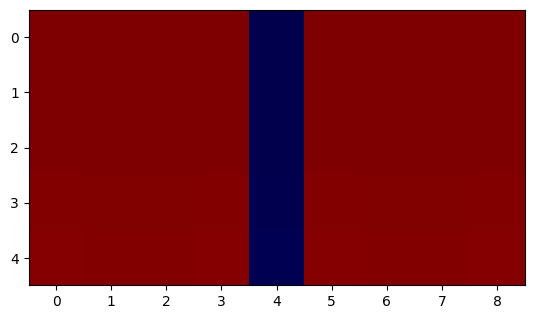

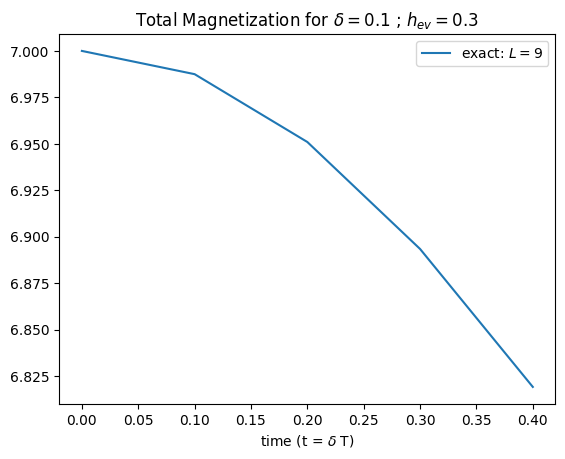

In [209]:
# visualization of exact evolution
# local
plt.imshow(mag_exact_loc, cmap='seismic', vmin=-1, vmax=1, aspect=1)
plt.show()
# total
plt.title(f"Total Magnetization for $\delta = {delta}$ ;" + " $h_{ev} =$" + f"{h_ev}")
plt.plot(delta*np.arange(trotter_steps+1), mag_exact_tot, label=f"exact: $L={L}$")
plt.xlabel("time (t = $\delta$ T)")
plt.legend()
plt.show()

Now we can try to do the same with MPS.
We need to implement the time evolution and compress the bond dimesion to allow larger chains.
This procedure works as follows:
- we apply the time ev mpo (bond dim = w) to an initial state (bond dim = m). To do that we variationally find an mps with bond dimension m' < w*m
- we minimize a distance measure between the mpo applied on the initial state and the variational compressed state.
- we take track of the error

In [210]:
# compression functions
def lin_sys(classe, M, N_eff, site, l_shape, r_shape):
    M_new = M.flatten()
    new_site = scipy.sparse.linalg.spsolve(N_eff, M_new)
    new_site = new_site.reshape((l_shape[0], classe.d, r_shape[0]))
    # print("Comparison with previous state:\n")
    # print(f"Old site:\n{classe.sites[site - 1]}")
    # print(f"New site:\n{new_site}")
    classe.sites[site - 1] = new_site
    return classe

def _braket(ket, bra, w):
    sandwich = ncon([ket,w,bra.conjugate()],[[-1,1,-4],[-2,-5,1,2],[-3,2,-6]])
    return sandwich

def _N_eff(classe, site):
        array = classe.sites
        a = np.array([1])
        env = ncon([a,a,a,a],[[-1],[-2],[-3],[-4]])

        for i in range(site-1):
            ten = classe.overlap_sites(array_1=array[i])
            env = ncon([env,ten],[[-1,-2,1,2],[1,2,-3,-4]])
        left = env
        left = ncon([a,a,left],[[1],[2],[1,2,-1,-2]])
        # print(csr_matrix(truncation(left, threshold=1e-15)))
        # plt.title("left")
        # plt.imshow(left.real, vmin=0, vmax=1)
        # plt.show()
        env = ncon([a,a,a,a],[[-1],[-2],[-3],[-4]])
        for i in range(classe.L-1, site-1, -1):
            ten = classe.overlap_sites(array_1=array[i])
            env = ncon([ten,env],[[-1,-2,1,2],[1,2,-3,-4]])
        right = env
        right = ncon([right,a,a],[[-1,-2,1,2],[1],[2]])
        # print(csr_matrix(truncation(right, threshold=1e-15)))
        # plt.title("right")
        # plt.imshow(right.real, vmin=0, vmax=1)
        # plt.show()
        kron = np.eye(2)
        # N = ncon([left,kron,right],[[-1,-4],[-2,-5],[-3,-6]]).reshape((classe.env_left[-1].shape[2]*classe.d*classe.env_right[-1].shape[2],classe.env_left[-1].shape[2]*classe.d*classe.env_right[-1].shape[2]))
        N = ncon([left,kron,right],[[-1,-4],[-2,-5],[-3,-6]]).reshape((left.shape[0]*classe.d*right.shape[0],left.shape[1]*classe.d*right.shape[1]))
        return N, left.shape, right.shape

def compute_M(classe, site, rev=False):
        """
        _compute_M

        This function computes the rank-3 tensor, in a specific site,
        given by the contraction of our variational state (phi) saved in classe.sites,
        and the uncompressed state (psi) saved in classe.ancilla_sites.

        site: int - site where to execute the tensor contraction

        """
        # array_1 = classe.ancilla_sites
        # array_2 = classe.sites
        # w = classe.w
        # if rev:
        #     array_1 = classe.sites
        #     array_2 = classe.ancilla_sites
        # a = np.array([1])
        # env = ncon([a,a,a],[[-1],[-2],[-3]])
        # classe.env_left.append(env)

        # for i in range(site-1):
        #     ten = _braket(ket=array_1[i], bra=array_2[i], w=w[i])
        #     env = ncon([env,ten],[[1,2,3],[1,2,3,-1,-2,-3]])
        # left = env
        # # print("The left overlap of the state:")
        # # print(left)
        # env = ncon([a,a,a],[[-1],[-2],[-3]])
        # right = env
        # for i in range(classe.L-1, site-1, -1):
        #     ten = _braket(ket=array_1[i], bra=array_2[i], w=w[i])
        #     # print(f"braket shape: {ten.shape}")
        #     # print(f"env shape: {env.shape}")
        #     env = ncon([ten,env],[[-1,-2,-3,1,2,3],[1,2,3]])
        # right = env
        # # print("The right overlap of the state:")

        # M = ncon([left,array_1[site - 1],w[site - 1],right],[[1,4,-1],[1,2,3],[4,5,2,-2],[3,5,-3]])
        M = ncon([classe.env_left[-1],classe.ancilla_sites[site-1],classe.w[site-1],classe.env_right[-1]],[[1,4,-1],[1,2,3],[4,5,2,-2],[3,5,-3]])
        return M

def compute_M_no_mpo(classe, site, rev=False):
        """
        _compute_M

        This function computes the rank-3 tensor, in a specific site,
        given by the contraction of our variational state (phi) saved in classe.sites,
        and the uncompressed state (psi) saved in classe.ancilla_sites.

        site: int - site where to execute the tensor contraction

        """
        array_1 = classe.ancilla_sites
        array_2 = classe.sites
        if rev:
            array_1 = classe.sites
            array_2 = classe.ancilla_sites
        a = np.array([1])
        env = ncon([a,a],[[-1],[-3]])

        for i in range(site-1):
            ten = ncon([array_1[i],array_2[i].conjugate()],[[-1,1,-3],[-2,1,-4]])
            env = ncon([env,ten],[[1,2],[1,2,-1,-2]])
        left = env
        # print("The left overlap of the state:")
        # print(left)
        env = ncon([a,a],[[-1],[-2]])
        for i in range(classe.L-1, site-1, -1):
            ten = ncon([array_1[i],array_2[i].conjugate()],[[-1,1,-3],[-2,1,-4]])
            # print(f"braket shape: {ten.shape}")
            # print(f"env shape: {env.shape}")
            env = ncon([ten,env],[[-1,-2,1,2],[1,2]])
        right = env
        # print("The right overlap of the state:")

        M = ncon([left,array_1[site - 1],right],[[1,-1],[1,-2,2],[2,-3]])
        # M = ncon([classe.env_left[-1],classe.ancilla_sites[site-1],classe.w[site-1],classe.env_right[-1]],[[1,4,-1],[1,2,3],[4,5,2,-2],[3,5,-3]])
        return M

def error(classe, site, M, N_eff):
    AM = ncon([M,classe.sites[site-1].conjugate()],[[1,2,3],[1,2,3]])
    A = classe.sites[site-1].flatten()
    AN_effA = ncon([A,N_eff,A.conjugate()],[[1],[1,2],[2]])
    error = AN_effA - 2*AM.real
    return error

def update_state(classe, sweep, site, trunc, e_tol=10 ** (-15), precision=2):   
        """
        update_state

        This function updates the classe.a and classe.b lists of tensors composing
        the mps. The update depends on the sweep direction. We take the classe.m
        extracted from the eigensolver and we decomposed via svd.

        sweep: string - direction of the sweeping. Could be "left" or "right"
        site: int - indicates which site the DMRG is optimizing
        trunc: bool - if True will truncate the the Schmidt values and save the
                state accordingly.
        e_tol: float - the tolerance accepted to truncate the Schmidt values
        precision: int - indicates the precision of the parameter h

        """
        if sweep == "right":
            # we want to write M (left,d,right) in LFC -> (left*d,right)
            m = classe.sites[site - 1].reshape(
                classe.sites[site - 1].shape[0] * classe.d, classe.sites[site - 1].shape[2]
            )
            # m = truncation(m, threshold=1e-16)
            # m = csr_matrix(m)
            # print(m)
            # u, s, v = scipy.sparse.linalg.svds(m, k=min(m.shape)-1)
            u, s, v = np.linalg.svd(m, full_matrices=False)
            
            print(f"Schmidt sum: {sum(s**2)}")
            if trunc:
                condition = s >= e_tol
                s_trunc = np.extract(condition, s)
                s = s_trunc / np.linalg.norm(s_trunc)
                bond_l = u.shape[0] // classe.d
                u = u.reshape(bond_l, classe.d, u.shape[1])
                u = u[:, :, : len(s)]
                v = v[: len(s), :]
            else:
                u = u.reshape(
                    classe.sites[site - 1].shape[0], classe.d, classe.sites[site - 1].shape[2]
                )
            next_site = ncon(
                [np.diag(s), v, classe.sites[site]], 
                [
                    [-1,1],
                    [1,2],
                    [2,-2,-3],
                ],
            )
            classe.sites[site - 1] = u
            classe.sites[site] = next_site

        elif sweep == "left":
            # we want to write M (left,d,right) in RFC -> (left,d*right)
            m = classe.sites[site - 1].reshape(
                classe.sites[site - 1].shape[0], classe.d * classe.sites[site - 1].shape[2]
            )
            u, s, v = np.linalg.svd(m, full_matrices=False)
            print(f"Schmidt sum: {sum(s**2)}")
            if trunc:
                condition = s >= e_tol
                s_trunc = np.extract(condition, s)
                s = s_trunc / np.linalg.norm(s_trunc)
                bond_r = v.shape[1] // classe.d
                v = v.reshape(v.shape[0], classe.d, bond_r)
                v = v[: len(s), :, :]
                u = u[:, : len(s)]
            else:
                v = v.reshape(
                    classe.sites[site - 1].shape[0], classe.d, classe.sites[site - 1].shape[2]
                )
            next_site = ncon(
                [classe.sites[site - 2], u, np.diag(s)], 
                [
                    [-1,-2,1],
                    [1,2],
                    [2,-3],
                ],
            )
            classe.sites[site - 1] = v
            classe.sites[site - 2] = next_site

        return classe

def compression(classe, trunc, e_tol=10 ** (-15), n_sweeps=2, precision=2):
    sweeps = ["right", "left"]
    sites = np.arange(1, classe.L + 1).tolist()
    errors = []

    classe.envs(mixed=True)
    iter = 1
    for n in range(n_sweeps):
        print(f"Sweep n: {n}\n")
        for i in range(classe.L - 1):
            print(f"\n============= Site: {sites[i]} ===================\n")
            N_eff, l_shape, r_shape = _N_eff(classe, site=sites[i])
            N_eff = truncation(array=N_eff, threshold=1e-15)
            N_eff_sp = csr_matrix(N_eff)
            print("After N_eff")
            classe._compute_norm(site=1)

            # plt.title("Real part")
            # plt.imshow(N_eff.real, cmap='viridis')
            # plt.show()
            # plt.title("Imaginary part")
            # plt.imshow(N_eff.imag, cmap='viridis')
            # plt.show()
            
            M = compute_M_no_mpo(classe, sites[i])
            t_plus_dt = ncon([classe.sites[sites[i]-1].conjugate(),M],[[1,2,3],[1,2,3]])
            print(f"The overlap of states phi and Opsi is: {t_plus_dt}")
            # A = classe.sites[sites[i]-1]
            # A_new = truncation(A, threshold=1e-16)
            # A_new = A_new.reshape(A_new.shape[0]*A_new.shape[1],A_new.shape[2])
            # A_new = csr_matrix(A_new)
            # print(A_new)
            # print(A.shape)
            print("After M")
            classe._compute_norm(site=1)

            # lin_sys(classe, M, N_eff_sp, sites[i], l_shape, r_shape)
            classe.sites[sites[i]-1] = M
            t_plus_dt = ncon([classe.sites[sites[i]-1].conjugate(),M],[[1,2,3],[1,2,3]])
            print(f"The overlap of states phi (updated) and Opsi is: {t_plus_dt}")
            # print("After linear system")
            # classe._compute_norm(site=1)
            
            err = error(classe,  site=sites[i], N_eff=N_eff, M=M)
            print("After err")
            classe._compute_norm(site=1)

            # print(f"error per site {sites[i]}: {err:.5f}")
            errors.append(err)
            update_state(classe, sweeps[0], sites[i], trunc, e_tol, precision)
            # classe.update_envs(sweeps[0], sites[i], mixed=True)
            print("After update state")
            # classe.canonical_form()
            classe._compute_norm(site=1)
            

            iter += 1

        sweeps.reverse()
        sites.reverse()
    
    return errors

Before compressing, we evolve the state at its maximum bond dimension since the chain is small.

The maximum bond dimension is $2^{L/2}$ so in our case $\chi_{max} = 2^{4} = 16 $. This $\chi_{max}$ is reached in $4$ trotter steps, hence we perform a direct application of the mpo anc compare with the exact time evolution

In [211]:
# main compression algorithm

# ground state
L = 9
chi = 16
chain = MPS(L=L, d=2, model='Ising', chi=chi, h=0, eps=0, J=1)
chain._random_state(seed=3, chi=chi)
chain.canonical_form()
chain.sweeping(trunc=True, n_sweeps=2)
chain.flipping_mps()

# local
mag_loc = []
for i in range(chain.L):
    chain.single_operator_Ising(site=i+1, op=Z)
    mag_loc.append(chain.mpo_first_moment())
print(f"Magnetization: {mag_loc}")

# total
mag_tot = []
chain.order_param_Ising(op=Z)
mag_tot.append(np.real(chain.mpo_first_moment()))

# fidelity
psi_mps = mps_to_vector(chain.sites)
fidelity = np.abs((exact_states[0].T.conjugate() @ psi_mps).real)
print(f'fidelity before evolution: {fidelity}')

Sweep n: 0

Sweep n: 1

Magnetization: [array(1.), array(1.), array(1.), array(1.), array(-1.), array(1.), array(1.), array(1.), array(1.)]
fidelity before evolution: 1.0


In [212]:
# direct mpo evolution
mag_tot_ev, mag_loc_ev, overlap = chain.direct_mpo_evolution(trotter_steps=trotter_steps, delta=delta, h_ev=h_ev, J_ev=1, fidelity=True, trunc=True)

# total
mag_mps_tot = mag_tot + mag_tot_ev

# local
mag_loc_ev.reverse()
mag_mps_loc = mag_loc_ev
mag_mps_loc.append(mag_loc)
mag_mps_loc.reverse()

# fidelity
overlap.reverse()
overlap.append(fidelity)
overlap.reverse()

------ Trotter steps: 0 -------
Bond dim: 2
(1, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 1)
------ Trotter steps: 1 -------
Bond dim: 4
(1, 2, 2)
(2, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 2)
(2, 2, 1)
------ Trotter steps: 2 -------
Bond dim: 8
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)
------ Trotter steps: 3 -------
Bond dim: 16
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)


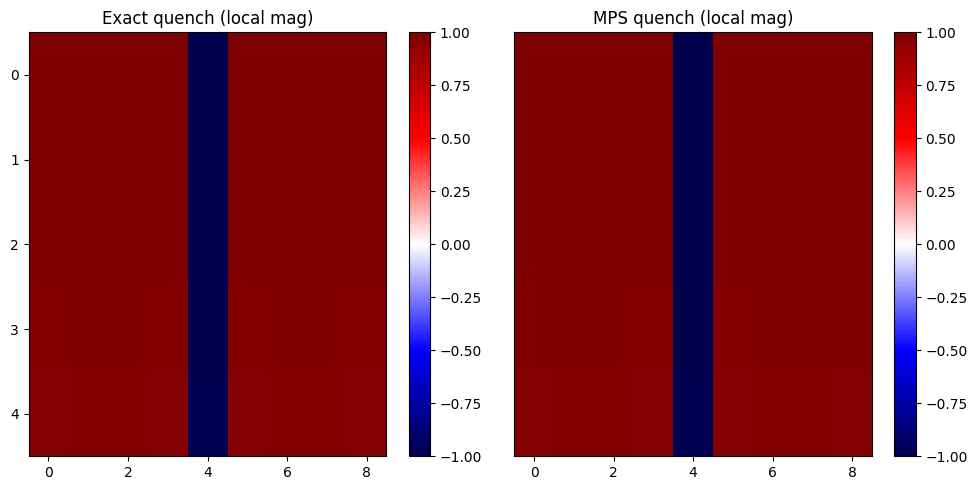

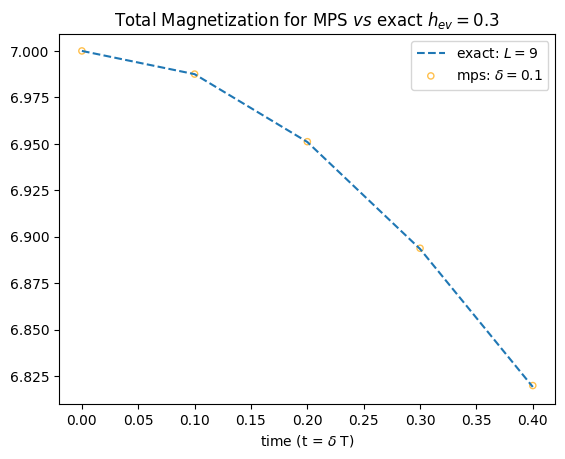

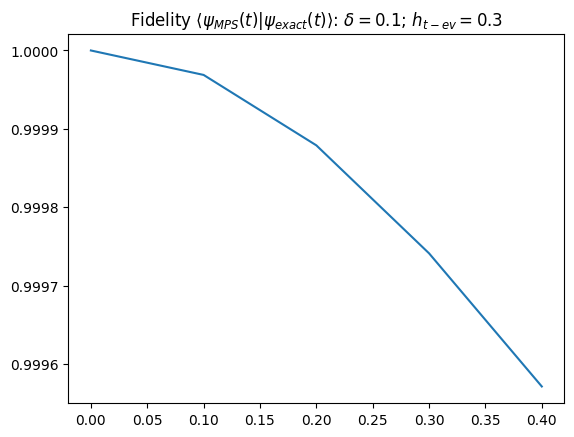

In [213]:
# visualization 

def plot_side_by_side_(data1, data2, cmap='viridis', title1='Imshow 1', title2='Imshow 2'):
    # Create a figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the imshow plots on the subplots
    im1 = ax1.imshow(data1, cmap=cmap, vmin=-1, vmax=1, aspect="auto")
    im2 = ax2.imshow(data2, cmap=cmap, vmin=-1, vmax=1, aspect="auto")

    # Set titles for the subplots
    ax1.set_title(title1)
    ax2.set_title(title2)

    # Remove ticks from the colorbar subplot
    # ax2.set_xticks([])
    ax2.set_yticks([])

    # Create a colorbar for the second plot on the right
    cbar = fig.colorbar(im2, ax=ax2)
    cbar = fig.colorbar(im1, ax=ax1)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Local data
data1 = mag_exact_loc
data2 = mag_mps_loc
title1 = "Exact quench (local mag)"
title2 = "MPS quench (local mag)"
plot_side_by_side_(data1=data1, data2=data2, cmap='seismic', title1=title1, title2=title2)

# total
# chi = chain.sites[L//2].shape[0]
plt.title(f"Total Magnetization for MPS $vs$ exact " + "$h_{ev} =$" + f"{h_ev}")
plt.plot(delta*np.arange(trotter_steps+1), mag_exact_tot, '--', label=f"exact: $L={L}$")
plt.scatter(delta*np.arange(trotter_steps+1), mag_mps_tot, s=20, marker='o', alpha=0.7, facecolors='none', edgecolors='orange', label=f"mps: $\delta={delta}$")
plt.xlabel("time (t = $\delta$ T)")
plt.legend()
plt.show()

# fidelity
plt.title("Fidelity $\left<\psi_{MPS}(t)|\psi_{exact}(t)\\right>$: " + f"$\delta = {delta}$; $h_{{t-ev}} = {h_ev}$")
plt.plot(delta*np.arange(trotter_steps+1), overlap)

In [214]:
# compressing during trotter evolution

# we can put the initial state in the ancilla sites argument
# chain._random_state(seed=3, chi=16, ancilla=True)
chain.ancilla_sites = chain.sites
chain.canonical_form()
chain._compute_norm(site=1)
# we use as a guess state the ground state that is already in sites
Z = np.array([[1,0],[0,-1]])

err_tot = []
n_sweeps = 4
trotter = 100
for t in range(trotter):
    print(f"------ Trotter steps: {t+4} -------")
    chain.mpo_Ising_time_ev(delta=delta, h_ev=h_ev, J_ev=1)
    chain._compute_norm(site=1)
    chain.mpo_to_mps()
    err = compression(chain, trunc=True, n_sweeps=n_sweeps)
    chain.ancilla_sites = chain.sites
    err_tot.append(err)

    # # local
    # mag = []
    # for i in range(chain.L):
    #     chain.single_operator_Ising(site=i+1, op=Z)
    #     mag.append(chain.mpo_first_moment().real)
    # mag_mps_loc.append(mag)
    # 

    # total
    chain.order_param_Ising(op=Z)
    mag_mps_tot.append(np.real(chain.mpo_first_moment()))
    
    # fidelity
    U_new = exact_evolution_operator(L=L, h_t=h_ev, delta=delta, trotter_step=t+5)
    psi_new = U_new @ psi_exact
    mag = (psi_new.T.conjugate() @ mag_tot_op @ psi_new).real
    mag_exact_tot.append(mag)
    psi_new_mps = mps_to_vector(chain.sites)
    overlap.append(np.abs((psi_new_mps.T.conjugate() @ psi_new).real))

-=-=-= Norm: 0.9999999999999996

------ Trotter steps: 4 -------
-=-=-= Norm: 0.9999999999999996

Sweep n: 0


============= Site: 1 ===================

After N_eff
-=-=-= Norm: 0.9999999999999997

The overlap of states phi and Opsi is: (0.9999999999999997-6.938893903907228e-17j)
After M
-=-=-= Norm: 0.9999999999999997

The overlap of states phi (updated) and Opsi is: (1.0948347240957552+0j)
After err
-=-=-= Norm: 1.1986635916595991

Schmidt sum: 1.0948347240957554
After update state
-=-=-= Norm: 1.0948351977506003


============= Site: 2 ===================

After N_eff
-=-=-= Norm: 1.0948351977506003

The overlap of states phi and Opsi is: (1.0948351977506-2.7755575615628914e-17j)
After M
-=-=-= Norm: 1.0948351977506003

The overlap of states phi (updated) and Opsi is: (1.1986667201508276+0j)
After err
-=-=-= Norm: 1.3123453730943109

Schmidt sum: 1.1986667201508276
After update state
-=-=-= Norm: 1.0948375816500335


============= Site: 3 ===================

After N_eff
-=-=-= Nor

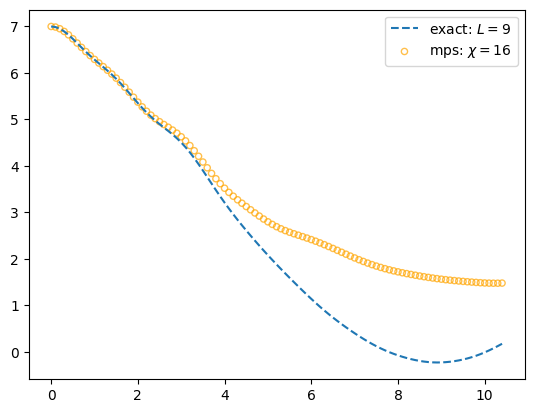

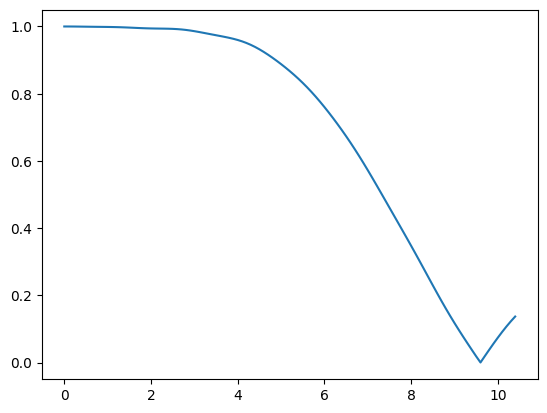

In [218]:
# visualization

# total
chi = chain.sites[L//2].shape[0]
plt.plot(delta*np.arange(trotter+5), mag_exact_tot, '--', label=f"exact: $L={L}$")
# plt.plot(delta*np.arange(trotter+5), mag_mps_tot, 'o', label=f"mps: $\chi={chi}$")
plt.scatter(delta*np.arange(trotter+5), mag_mps_tot, s=20, marker='o', alpha=0.7, facecolors='none', edgecolors='orange', label=f"mps: $\chi={chi}$")
plt.legend()
plt.show()

# fidelity
# overlap.reverse()
# overlap.append(fidelity)
# overlap.reverse()
plt.plot(delta*np.arange(trotter+5), overlap)

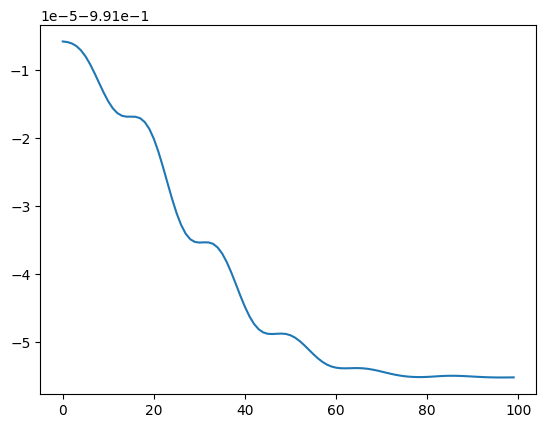

In [216]:
plt.plot(np.asarray(err_tot)[:,0].real)
a = np.linspace(0, len(err_tot)-1, n_sweeps)
# for sw in a:
#     plt.vlines(sw, ymin=min(err_tot),ymax=max(err_tot), colors='violet', linestyles='dashed')

In [217]:
np.asarray(err_tot)[:,0].real

array([-0.99100586, -0.99100594, -0.99100614, -0.99100653, -0.99100716,
       -0.99100805, -0.99100919, -0.99101053, -0.99101197, -0.99101339,
       -0.99101466, -0.99101567, -0.99101637, -0.99101676, -0.99101689,
       -0.99101689, -0.99101691, -0.99101712, -0.99101768, -0.99101867,
       -0.99102014, -0.99102204, -0.99102426, -0.99102662, -0.99102895,
       -0.99103106, -0.99103279, -0.99103407, -0.99103488, -0.99103527,
       -0.99103536, -0.99103533, -0.99103534, -0.99103555, -0.99103607,
       -0.99103697, -0.99103822, -0.99103975, -0.99104145, -0.99104317,
       -0.9910448 , -0.9910462 , -0.9910473 , -0.99104807, -0.99104854,
       -0.99104874, -0.99104878, -0.99104874, -0.99104871, -0.99104877,
       -0.99104896, -0.99104931, -0.9910498 , -0.9910504 , -0.99105106,
       -0.99105172, -0.99105234, -0.99105286, -0.99105326, -0.99105355,
       -0.99105372, -0.99105379, -0.99105381, -0.9910538 , -0.99105378,
       -0.99105378, -0.99105381, -0.99105389, -0.991054  , -0.99